In [2]:
import pandas as pd
import json
import os

# Check current working directory
# print(os.getcwd())

# Load the JSON file from the specified path
with open(r"../raw_data/Attestations.json") as f:
    data = json.load(f)

# Display loaded data (optional)
# display(data)

# Normalize/flatten the nested structure
attestations = pd.json_normalize(data['data']['attestations'])

# Further process 'decodedDataJson' to parse it as JSON
attestations['decodedDataJson'] = attestations['decodedDataJson'].apply(json.loads)

# Expand 'decodedDataJson' column into separate columns
decoded_data = attestations['decodedDataJson'].apply(pd.Series)

# Create an empty DataFrame for the flattened decoded data
decoded_flattened = pd.DataFrame()

# Extract and flatten each 'value' field from 'decodedDataJson'
for index, row in decoded_data.iterrows():
    flat_row = {}
    for item in row:
        if isinstance(item, dict):
            flat_row[item['name']] = item['value']['value']
    # Concatenate each new row
    decoded_flattened = pd.concat([decoded_flattened, pd.DataFrame([flat_row])], ignore_index=True)

# Merge the decoded_flattened dataframe back to attestations
final_df = pd.concat([attestations.drop(columns=['decodedDataJson']), decoded_flattened], axis=1)

# Filter rows where 'type' is 'attendee_met'
filtered_df = final_df[final_df['type'] == 'attendee_met']

# Reset index after filtering
filtered_df = filtered_df.reset_index(drop=True)

# Display the flattened DataFrame
# print(final_df)
# display(filtered_df)

# Path to save the flattened DataFrame
root_dir = os.getcwd()  # Define root_dir if not defined
output_json_path = os.path.join(root_dir, "flattened_attestations.json")

# Save to JSON
filtered_df.to_json(output_json_path, index=False)

In [3]:
# Iterate over each row in filtered_df and print the UUID for each row
for index, row in filtered_df.iterrows():
    uuid = row['uuid']
    print(f"Row {index} UUID: {uuid}")

# Initialize an empty list to store UUIDs
uuid_list = []

# Iterate over each row in filtered_df and store the UUIDs
for index, row in filtered_df.iterrows():
    uuid = row['uuid']
    uuid_list.append(uuid)

# Print the total number of UUIDs collected
print(f"Total number of UUIDs: {len(uuid_list)}")

# Get all unique UUIDs from the 'uuid' column
unique_uuids = filtered_df['uuid'].unique()

# Convert numpy array to a list
unique_uuids_list = unique_uuids.tolist()

# Print the total number of unique UUIDs
print(f"Total number of unique UUIDs: {len(unique_uuids_list)}")

# Get the count of each unique UUID and convert to DataFrame
uuid_counts = filtered_df['uuid'].value_counts().reset_index()

# Rename the columns for clarity
uuid_counts.columns = ['uuid', 'count']

# Print the DataFrame of UUID counts
print("\nUUID Counts DataFrame:")
print(uuid_counts)

# Optionally, display the UUID counts DataFrame in your environment
display(uuid_counts)


Row 0 UUID: 3x9xo
Row 1 UUID: qguv3
Row 2 UUID: cm7ze
Row 3 UUID: 9p5oq
Row 4 UUID: 7xwi5
Row 5 UUID: oujki
Row 6 UUID: 0nnx3
Row 7 UUID: dfkvv
Row 8 UUID: u1utz
Row 9 UUID: k6wd5
Row 10 UUID: q59yc
Row 11 UUID: ad8pv
Row 12 UUID: 004bw
Row 13 UUID: venvc
Row 14 UUID: f3vp0
Row 15 UUID: g5ou0
Row 16 UUID: 8py6m
Row 17 UUID: znb6t
Row 18 UUID: omqyd
Row 19 UUID: 3y5nx
Row 20 UUID: 3he7c
Row 21 UUID: e7kmh
Row 22 UUID: ft53n
Row 23 UUID: e70u9
Row 24 UUID: bztu7
Row 25 UUID: g1i4q
Row 26 UUID: 6yvoa
Row 27 UUID: ystvo
Row 28 UUID: 8wf23
Row 29 UUID: j4jjz
Row 30 UUID: bgsup
Row 31 UUID: r7y70
Row 32 UUID: nxzzq
Row 33 UUID: 8r2qk
Row 34 UUID: fw44f
Row 35 UUID: oue3j
Row 36 UUID: iy5mt
Row 37 UUID: 9p5oq
Row 38 UUID: cpnid
Row 39 UUID: cvuvy
Row 40 UUID: 3oaow
Row 41 UUID: 1wumb
Row 42 UUID: qbdri
Row 43 UUID: c7id4
Row 44 UUID: ynpod
Row 45 UUID: t9h3c
Row 46 UUID: qooay
Row 47 UUID: 9vuyo
Row 48 UUID: z5eng
Row 49 UUID: d1bzh
Row 50 UUID: bcryt
Row 51 UUID: 9seen
Row 52 UUID: t9f3s
Row

,uuid,count
0,3x9xo,2
1,jnpzd,2
2,1pnjg,2
3,g6sbv,2
4,rf5dy,2
...,...,...
464,r5qi5,1
465,637nd,1
466,2t38s,1
467,oev21,1


In [25]:
# Initialize an empty list to store the results
hacker_pairs = []

# Iterate over each unique UUID
for uuid in unique_uuids_list:
    # Filter the DataFrame for rows matching the current UUID
    uuid_filtered_df = filtered_df[filtered_df['uuid'] == uuid]
    
    # Check the number of rows in the filtered dataframe
    if len(uuid_filtered_df) == 1:
        # If there is only 1 row, make the 'recipient' value the 'hacker1'
        hacker1 = uuid_filtered_df.iloc[0]['recipient']
        hacker_pairs.append({'uuid': uuid, 'hacker1': hacker1, 'hacker2': None})  # No hacker2
    
    elif len(uuid_filtered_df) == 2:
        # If there are 2 rows, assign the first row's 'recipient' to 'hacker1' and second row's to 'hacker2'
        hacker1 = uuid_filtered_df.iloc[0]['recipient']
        hacker2 = uuid_filtered_df.iloc[1]['recipient']
        hacker_pairs.append({'uuid': uuid, 'hacker1': hacker1, 'hacker2': hacker2})

# Convert the hacker_pairs list into a DataFrame
hacker_df = pd.DataFrame(hacker_pairs)

# Filter the DataFrame where 'hacker2' is not None
hacker_df = hacker_df[hacker_df['hacker2'].notnull()]

# Add a new column to count the occurrences of each value in both 'hacker1' and 'hacker2' columns
hacker_all_counts = pd.concat([hacker_df['hacker1'], hacker_df['hacker2']]).value_counts()

# Create two new columns 'hacker1_count' and 'hacker2_count' based on the occurrences in both columns
hacker_df['hacker1_count'] = hacker_df['hacker1'].map(hacker_all_counts)
hacker_df['hacker2_count'] = hacker_df['hacker2'].map(hacker_all_counts)

# Convert 'hacker2_count' to an integer (ignoring NaN values)
hacker_df['hacker2_count'] = hacker_df['hacker2_count'].fillna(0).astype(int)

# Sort the DataFrame by 'hacker1_count' in descending order
hacker_df = hacker_df.sort_values(by='hacker1_count', ascending=False).reset_index(drop=True)

# Save the DataFrame in a row-oriented format (list of dictionaries)
hacker_df.to_json('../data/final_hacker_data.json', orient='records', lines=False)

# Display the final hacker DataFrame
print("\nFinal hacker DataFrame:")
display(hacker_df)



Final hacker DataFrame:


,uuid,hacker1,hacker2,hacker1_count,hacker2_count
0,t98fu,0xf6B6F07862A02C85628B3A9688beae07fEA9C863,0x9CEB440A36Fd613e219776c928f83A9578f424d1,34,5
1,q8g8x,0xf6B6F07862A02C85628B3A9688beae07fEA9C863,0x24fB753562A74859f794C7584dac0cD9d44b2cF4,34,6
2,u59m4,0xf6B6F07862A02C85628B3A9688beae07fEA9C863,0x63A556c75443b176b5A4078e929e38bEb37a1ff2,34,4
3,8u9sc,0xf6B6F07862A02C85628B3A9688beae07fEA9C863,0xDEf1F7C203c3E9Dda5E733C61d9Cc57dcf4e9b24,34,4
4,opgr5,0xf6B6F07862A02C85628B3A9688beae07fEA9C863,0xffFff449F1A35Eb0fAcCA8D4659D8E15CF2f77Ba,34,2
5,3he7c,0xf6B6F07862A02C85628B3A9688beae07fEA9C863,0xcb42Ac441fCade3935243Ea118701f39AA004486,34,2
6,g6sbv,0xf6B6F07862A02C85628B3A9688beae07fEA9C863,0xb915224a67e9a09BCA3D96685A6C7711FDa33c85,34,5
7,8py6m,0xf6B6F07862A02C85628B3A9688beae07fEA9C863,0x8c2641b5915171845EfDdC9fcAc20427B9347fF4,34,1
8,s70r1,0xf6B6F07862A02C85628B3A9688beae07fEA9C863,0x198fd437bCDDd7d962db55fce21E387C2F288Bdf,34,1
9,r7y70,0xf6B6F07862A02C85628B3A9688beae07fEA9C863,0x3d5Ef8d9996fF5adaef0990934673b9EBedb90ef,34,2


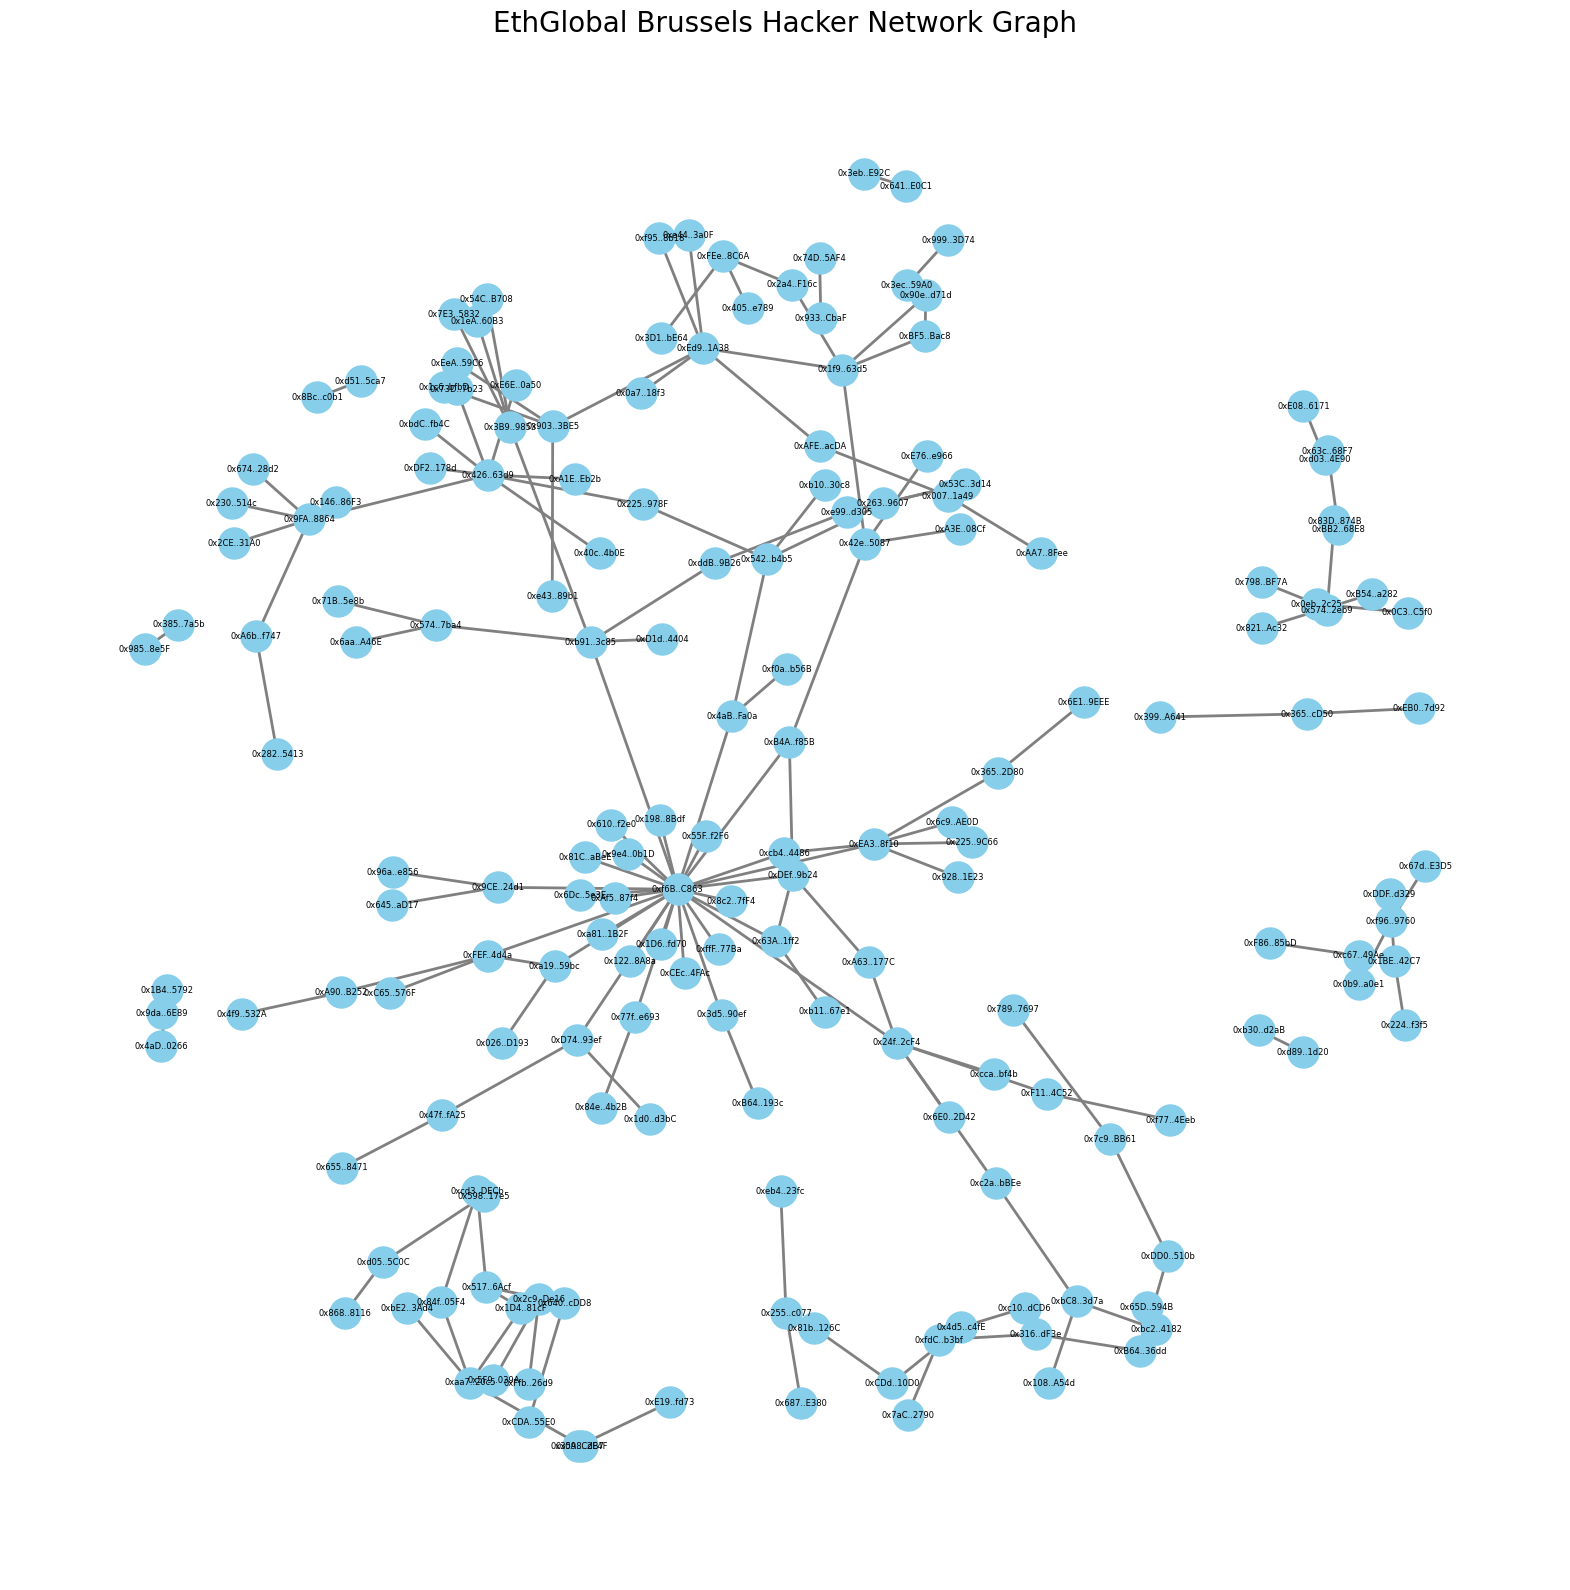

In [48]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to format recipient as first 5 characters + "..." + last 4 characters
def format_recipient(recipient):
    if isinstance(recipient, str) and len(recipient) > 9:
        return f"{recipient[:5]}..{recipient[-4:]}"
    return recipient

# Apply the formatting function to both hacker1 and hacker2 columns
hacker_df['hacker1'] = hacker_df['hacker1'].apply(format_recipient)
hacker_df['hacker2'] = hacker_df['hacker2'].apply(format_recipient)

# Create a new graph object
G = nx.Graph()

# Add edges to the graph from hacker_df where both hacker1 and hacker2 are present
for index, row in hacker_df.iterrows():
    hacker1 = row['hacker1']
    hacker2 = row['hacker2']
    
    # Only add an edge if hacker2 is not None (i.e., we have a valid pair)
    if hacker2:
        G.add_edge(hacker1, hacker2)

# Set up larger plot size and increase layout spread factor
plt.figure(figsize=(20, 20))  # Larger figure size for better zooming

# Increase the `k` value in spring_layout to spread nodes farther apart
pos = nx.spring_layout(G, k=0.9, iterations=300)  # Adjust k to control node spacing

# Draw nodes with adjusted size
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)

# Draw edges with slightly thicker lines
nx.draw_networkx_edges(G, pos, edge_color='gray', width=2)

# Draw labels with smaller font size for better readability
nx.draw_networkx_labels(G, pos, font_size=6, font_color='black')

# Save the plot as a high-resolution image for better zooming
plt.title("EthGlobal Brussels Hacker Network Graph", fontsize=20)
plt.axis('off')  # Turn off axis for a cleaner look

# Save the figure as a high-resolution PNG image
plt.savefig("hacker_network_graph.png", format="PNG", dpi=300, bbox_inches='tight')

# Display the network graph
plt.show()

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


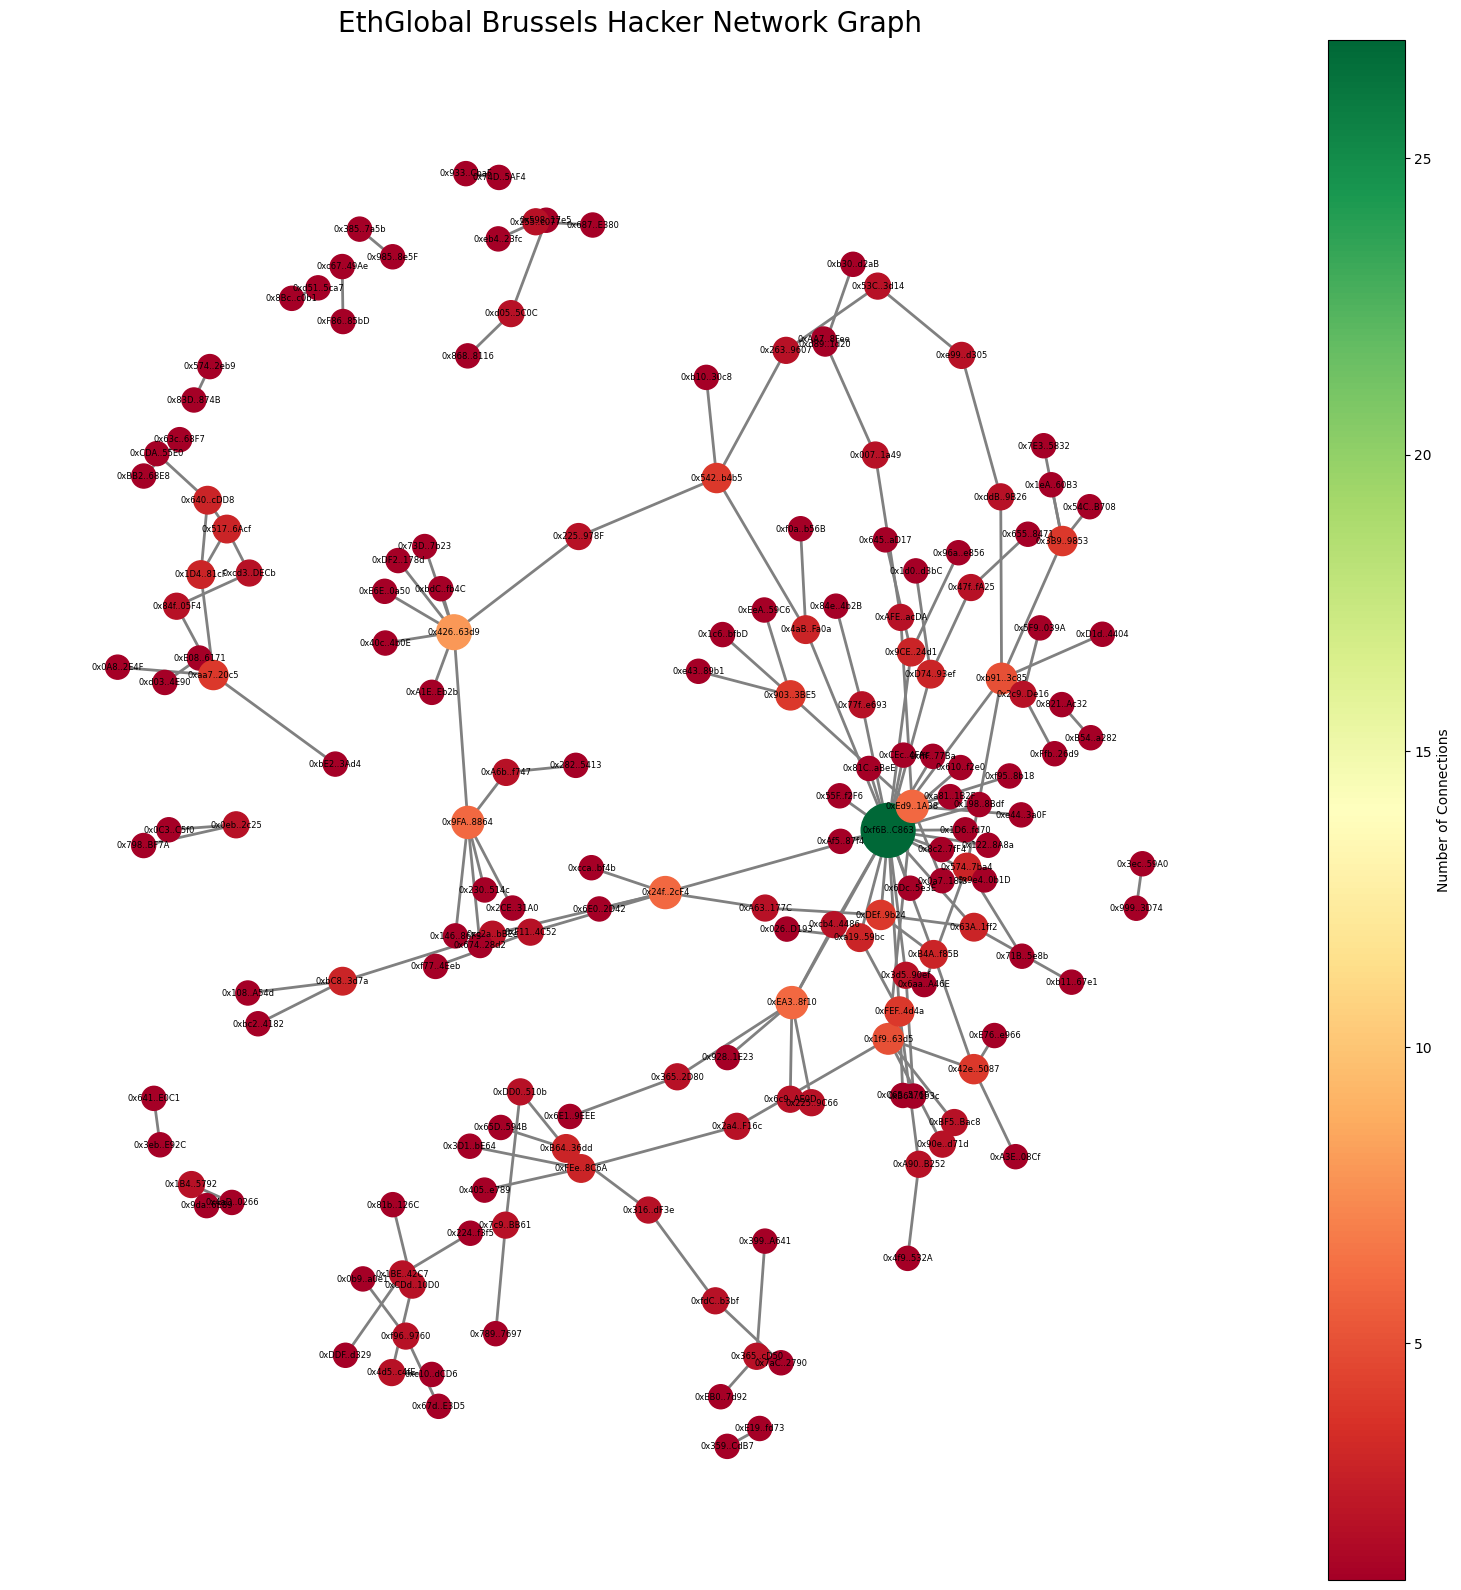

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Function to format recipient as first 5 characters + "..." + last 4 characters
def format_recipient(recipient):
    if isinstance(recipient, str) and len(recipient) > 9:
        return f"{recipient[:5]}..{recipient[-4:]}"
    return recipient

# Apply the formatting function to both hacker1 and hacker2 columns
hacker_df['hacker1'] = hacker_df['hacker1'].apply(format_recipient)
hacker_df['hacker2'] = hacker_df['hacker2'].apply(format_recipient)

# Create a new graph object
G = nx.Graph()

# Add edges to the graph from hacker_df where both hacker1 and hacker2 are present
for index, row in hacker_df.iterrows():
    hacker1 = row['hacker1']
    hacker2 = row['hacker2']
    
    # Only add an edge if hacker2 is not None (i.e., we have a valid pair)
    if hacker2:
        G.add_edge(hacker1, hacker2)

# Calculate the degree (number of connections) for each node
degrees = dict(G.degree())

# Get the minimum and maximum degree values
min_degree = min(degrees.values())
max_degree = max(degrees.values())

# Normalize the degree values to use them for node size and color scale
# Node size will range from 300 to 1500, and node color from green to red
node_sizes = [300 + 1200 * (degrees[node] - min_degree) / (max_degree - min_degree) for node in G.nodes()]
node_colors = [plt.cm.RdYlGn((degrees[node] - min_degree) / (max_degree - min_degree)) for node in G.nodes()]

# Set up larger plot size and increase layout spread factor
fig, ax = plt.subplots(figsize=(20, 20))  # Create figure and axis

# Use spring layout to spread nodes farther apart
pos = nx.spring_layout(G, k=0.9, iterations=300)

# Draw nodes with proportional size and color based on the number of connections
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, cmap=plt.cm.RdYlGn, ax=ax)

# Draw edges with slightly thicker lines
nx.draw_networkx_edges(G, pos, edge_color='gray', width=2, ax=ax)

# Draw labels with smaller font size for better readability
nx.draw_networkx_labels(G, pos, font_size=6, font_color='black', ax=ax)

# Add a colorbar to show the scale of the color mapping
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=min_degree, vmax=max_degree))
sm.set_array([])  # Only required to create the colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of Connections')

# Save the plot as a high-resolution image for better zooming
plt.title("EthGlobal Brussels Hacker Network Graph", fontsize=20)
plt.axis('off')  # Turn off axis for a cleaner look

# Save the figure as a high-resolution PNG image
plt.savefig("../figures/hacker_network_graph.png", format="PNG", dpi=300, bbox_inches='tight')

# Display the network graph
plt.show()

In [16]:
# # Display all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)